In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
import colorcet as cc

## Carga y limpieza


In [121]:
df = pd.read_csv("predicciones_WTA.csv")
df.head()

,winner,loser,m_winner,m_loser,s_winner,s_loser,b_winner,b_loser
0,Castano C.,Golds S.,0.0,0.0,2.5,2.5,1.33,3
1,Sequera M.,Ivanova E.,0.0,0.0,2.5,2.5,3.75,1.22
2,Bremond S.,Benesova I.,0.0,0.0,2.5,2.5,1.72,2
3,Hingis M.,Bammer S.,0.0,0.0,2.5,2.5,1.83,1.83
4,Vesnina E.,Camerin M.E.,0.0,0.0,2.5,2.5,1.16,4.5


In [122]:
# Eliminar filas con datos faltantes
df.dropna(inplace=True)

# Convertir a minúsculas los nombres de los jugadores para evitar problemas de comparación
df["winner"] = df["winner"].str.lower()
df["loser"] = df["loser"].str.lower()

# Verificar que no haya duplicados
df.drop_duplicates(inplace=True)

# Corregir strings mal formateados en columnas numéricas (e.g., '5..5' → '5.5')
cols_to_fix = ["m_winner", "m_loser", "s_winner", "s_loser", "b_winner", "b_loser"]
for col in cols_to_fix:
    df[col] = df[col].astype(str).str.replace(r"\.\.+", ".", regex=True)
    df[col] = df[col].str.replace(r"[^0-9\.]", "", regex=True)
    df[col] = df[col].astype(float)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31795 entries, 0 to 32050
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   winner    31795 non-null  object 
 1   loser     31795 non-null  object 
 2   m_winner  31795 non-null  float64
 3   m_loser   31795 non-null  float64
 4   s_winner  31795 non-null  float64
 5   s_loser   31795 non-null  float64
 6   b_winner  31795 non-null  float64
 7   b_loser   31795 non-null  float64
dtypes: float64(6), object(2)
memory usage: 2.2+ MB


## Probabilidad de ganar para un match dado las distribuciones de habilidad a priori.


La probabilidad de que el jugador con mayor habilidad estimada gane el partido, según el modelo de TrueSkill, se calcula como:

$$
P(\text{ganador} > \text{perdedor}) = \Phi\left( \frac{\mu_{\text{ganador}} - \mu_{\text{perdedor}}}{\sqrt{2} \cdot \beta} \right)
$$

Donde:

- $\Phi$ es la función de distribución acumulada de la normal estándar.
- $\mu_{\text{ganador}}$ y $\mu_{\text{perdedor}}$ son las medias estimadas de habilidad de cada jugador.
- $\beta$ es el parámetro de escala que define la dispersión del rendimiento en el modelo (por defecto, $\beta = 1$ en TTT).


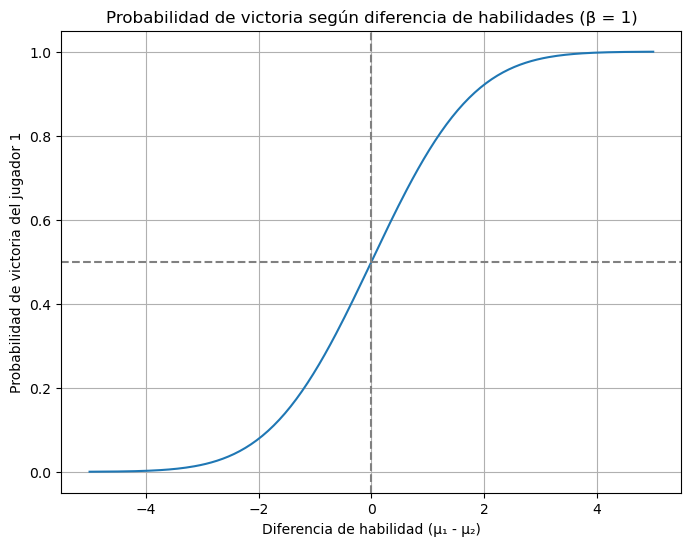

In [123]:
# Definir beta
beta = 1.0

# Rango de diferencias de habilidad
delta_mu = np.linspace(-5, 5, 200)

# Probabilidad de victoria en función de la diferencia de mu
p_win = norm.cdf(delta_mu / (np.sqrt(2) * beta))

# Graficar
plt.figure(figsize=(8, 6))
plt.plot(delta_mu, p_win)
plt.axvline(x=0, color="gray", linestyle="--")
plt.axhline(y=0.5, color="gray", linestyle="--")
plt.xlabel("Diferencia de habilidad (μ₁ - μ₂)")
plt.ylabel("Probabilidad de victoria del jugador 1")
plt.title("Probabilidad de victoria según diferencia de habilidades (β = 1)")
plt.grid(True)
plt.show()

In [124]:
beta = 1  # default del modelo TTT

# Calcular la probabilidad implícita de victoria basada en las medias
df["p_model"] = norm.cdf((df["m_winner"] - df["m_loser"]) / (np.sqrt(2) * beta))

df[["m_winner", "m_loser", "p_model"]].tail()

,m_winner,m_loser,p_model
32046,3.061060,3.178249,0.466980
32047,3.327833,3.179309,0.541821
32048,3.125128,3.079130,0.512973
32049,3.654975,3.396808,0.572425
32050,3.714950,3.183377,0.646496


## Calibracion de la probabilidad de ganar


### Brier Score

El **Brier Score** es una métrica para evaluar la precisión de probabilidades predichas para eventos binarios. Se define como:

$$
\text{Brier Score} = \frac{1}{N} \sum_{i=1}^N (p_i - o_i)^2
$$

Donde:

- $p_i$ es la probabilidad predicha por el modelo .
- $o_i$ es el resultado observado: $1$ si el evento ocurrió (ganó A).
- $N$ es el número total de predicciones.

El Brier Score toma valores entre 0 y 1:

- Un **score de 0** indica **predicciones perfectas**.
- Un **score de 1** indica **predicciones completamente erróneas**.
- Un **modelo perfectamente calibrado y aleatorio** obtendría un valor cercano a **0.25** si las probabilidades están siempre cerca de 0.5.
- Un modelo bien calibrado tendrá un **Brier Score bajo**, especialmente si además es capaz de separar bien los casos donde el evento es más o menos probable.


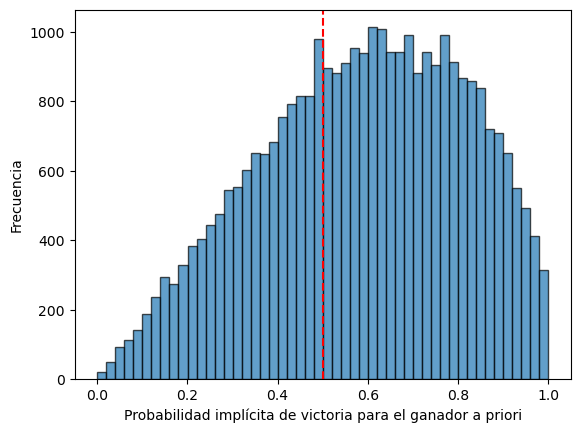

In [125]:
plt.hist(df["p_model"], bins=50, edgecolor="black", alpha=0.7)
plt.xlabel("Probabilidad implícita de victoria para el ganador a priori")
plt.ylabel("Frecuencia")

plt.axvline(x=0.5, color="red", linestyle="--", label="Probabilidad 50%")

In [126]:
# Brier score: mean squared error between predicted probability and actual outcome (1 for winner)
brier_score = np.mean((df["p_model"] - 1) ** 2)
print(f"Brier score: {brier_score:.4f}")

Brier score: 0.2221


## Metricas para evaluar las estrategias


**1. Tasa de Crecimiento (CAGR)**  
Mide el crecimiento promedio compuesto del capital, en este caso por apuesta.

$$
\text{CAGR} = \left(\frac{\text{Valor Final}}{\text{Valor Inicial}}\right)^{\frac{1}{T}} - 1
$$

**2. Ratio de Sharpe**  
Evalúa el retorno ajustado por riesgo comparando el exceso de retorno sobre la tasa libre de riesgo con la volatilidad. En apuestas la tasa libre de riesgo se puede considerar como 0, ya que no hay un activo sin riesgo en este contexto.

$$
\text{Sharpe} = \frac{\overline{R} - R_f}{\sigma_R}
$$

**3. Máxima Caída (Max Drawdown)**  
Mayor pérdida porcentual desde un pico hasta un mínimo posterior en el capital acumulado.


## ESTRATEGIAS:


OBS: En un escenario realista no empezaria a hacer predicciones desde el primer partido, dado que el modelo no tiene suficiente informacion de los jugadores para hacer predicciones informativas. Estaria basando mis apuesta en metricas de habilidad que reflejan mayormente el prior sobre la habilidad de los jugadores.

- Por esto empiezo a hacer predicciones despues de observar 5000 partidos.

El capital tiene a hacerse enorme, debido al gran numero de apuestas, por eso trabajo en escala logaritmica.

- Capital inicial: 1 USD, 0 en escala logaritmica.


In [127]:
df_bet = df.iloc[5000:].copy()

### 1. Estrategia inspirada en Kelly / Kelly fraccional


- Primero evaluo el EV de apostar por cada jugador, dada la probabilidad de ganar que asigno a cada jugador y los odds.
- Si ambos jugadores tienen EV positivo, apuesto por el jugador con mayor EV. Si ambos tienen EV negativo, no apuesto.
- Cuando apuesto, apuesto la fraccion de Kelly $f_kelly$ o una fraccion de esta, dependiendo de la estrategia.

$f_{kelly} = \frac{p \cdot b - 1}{(b-1)}$

con $p$ la probabilidad de ganar, $b$ las odds decimales y $f_{kelly}$ la fraccion de Kelly.


In [281]:
def kelly_fractional(df=df_bet, frac=0.5):
    log_returns = []
    log_capital = [0]  # log(1) = 0

    for i, row in df.iterrows():
        p_win = row["p_model"]
        p_lose = 1 - p_win
        o_win = row["b_winner"]
        o_lose = row["b_loser"]

        # Fracciones de Kelly (f*) para cada jugador
        f_win = (p_win * o_win - 1) / (o_win - 1) if o_win > 1 else 0
        f_lose = (p_lose * o_lose - 1) / (o_lose - 1) if o_lose > 1 else 0

        # Ajustar fracciones para kelly fraccional
        f_win = frac * f_win
        f_lose = frac * f_lose

        # Apuesto al maximo EV, ie: fraccion maxima.
        if f_win > 0 or f_lose > 0:
            if f_win >= f_lose:
                # Apostamos al eventual ganador
                r = np.log(1 + f_win * (o_win - 1))  # ganamos
            else:
                # Apostamos al perdedor
                if f_lose >= 1:
                    continue  # evitamos valores inválidos
                r = np.log(1 - f_lose)  # perdemos lo apostado

            log_returns.append(r)
            log_capital.append(log_capital[-1] + r)
        else:
            log_returns.append(0)
            log_capital.append(log_capital[-1])

    # Convertimos a arrays
    log_returns = np.array(log_returns)
    log_capital = np.array(log_capital[1:])  # quitamos capital inicial

    # Métricas
    T = len(log_returns)
    cagr = np.exp((log_capital[-1] - log_capital[0]) / T) - 1 if T > 0 else 0
    sharpe = log_returns.mean() / log_returns.std() if log_returns.std() > 0 else 0
    log_peak = np.maximum.accumulate(log_capital)
    log_drawdown = log_peak - log_capital
    max_dd = 1 - np.exp(-np.max(log_drawdown))

    print(f"Estrategia basada en kelly fraccional con fracción {frac:.2f}")
    print(f"CAGR: {cagr:.4f}")
    print(f"Sharpe Ratio: {sharpe:.4f}")
    print(f"Max Drawdown: {max_dd:.2%} \n")
    return log_capital, log_returns, cagr, sharpe, max_dd

In [282]:
log_capital, log_returns, cagr, sharpe, max_dd = kelly_fractional(df_bet, frac=1)

Estrategia basada en kelly fraccional con fracción 1.00
CAGR: -0.0517
Sharpe Ratio: -0.1186
Max Drawdown: 100.00% 



In [283]:
def plot_strategy(
    log_capital,
    log_returns,
    cagr,
    sharpe,
    max_dd,
    title=None,
    label=None,
    show_metrics=False,
    color=None,
):
    # If no current figure exists, create one
    if not plt.get_fignums():
        plt.figure(figsize=(14, 6))
        plt.subplot(1, 2, 1)
    else:
        plt.figure(plt.gcf().number)
        plt.subplot(1, 2, 1)

    steps = np.arange(len(log_capital))

    plt.plot(
        steps,
        log_capital,
        label=label if label else "Log(Capital)",
        color=color,
        linewidth=1,
    )
    plt.xlabel("Apuesta N°")
    plt.ylabel("Log(Capital)")
    plt.grid(True)
    plt.title(title)

    if show_metrics:
        metrics_text = (
            f"CAGR: {cagr:.4f}\n"
            f"Sharpe Ratio: {sharpe:.4f}\n"
            f"Max Drawdown: {max_dd:.2%}"
        )
        plt.gca().text(
            0.05,
            0.15,
            metrics_text,
            transform=plt.gca().transAxes,
            fontsize=12,
            verticalalignment="top",
            bbox=dict(boxstyle="round,pad=0.4", facecolor="white", alpha=0.8),
        )

    plt.legend()
    plt.tight_layout()

Estrategia basada en kelly fraccional con fracción 0.01
CAGR: 0.0004
Sharpe Ratio: 0.0799
Max Drawdown: 11.69% 

Estrategia basada en kelly fraccional con fracción 0.11
CAGR: 0.0032
Sharpe Ratio: 0.0622
Max Drawdown: 76.57% 

Estrategia basada en kelly fraccional con fracción 0.21
CAGR: 0.0041
Sharpe Ratio: 0.0436
Max Drawdown: 94.79% 

Estrategia basada en kelly fraccional con fracción 0.31
CAGR: 0.0033
Sharpe Ratio: 0.0247
Max Drawdown: 99.77% 

Estrategia basada en kelly fraccional con fracción 0.41
CAGR: 0.0009
Sharpe Ratio: 0.0054
Max Drawdown: 100.00% 

Estrategia basada en kelly fraccional con fracción 0.51
CAGR: -0.0030
Sharpe Ratio: -0.0142
Max Drawdown: 100.00% 

Estrategia basada en kelly fraccional con fracción 0.60
CAGR: -0.0084
Sharpe Ratio: -0.0340
Max Drawdown: 100.00% 

Estrategia basada en kelly fraccional con fracción 0.70
CAGR: -0.0156
Sharpe Ratio: -0.0543
Max Drawdown: 100.00% 

Estrategia basada en kelly fraccional con fracción 0.80
CAGR: -0.0247
Sharpe Ratio: -0

Text(0.5, 1.0, 'Estrategias de Kelly Fraccional')

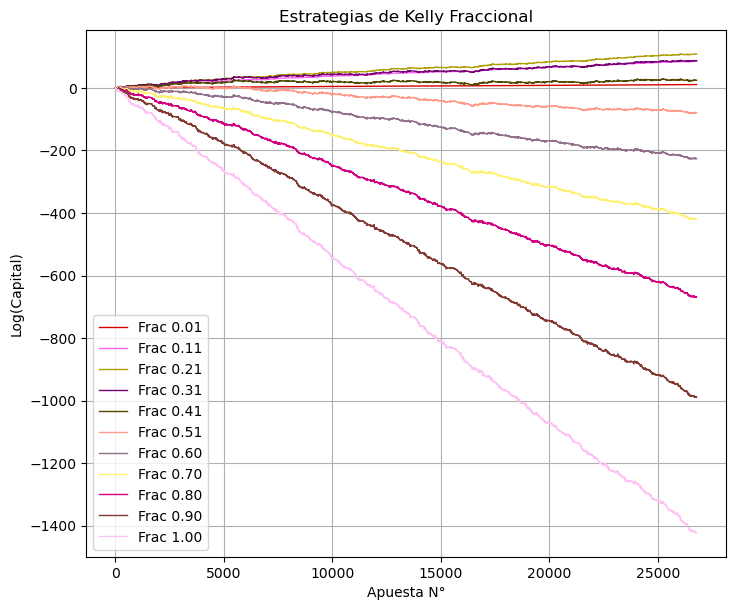

In [284]:
fracs = np.linspace(0.01, 1, 11)
n = len(fracs)
_sharpe = []
_max_dd = []
_CAGR = []

for i, frac in enumerate(fracs):
    log_capital, log_returns, cagr, sharpe, max_dd = kelly_fractional(df_bet, frac=frac)
    _sharpe.append(sharpe)
    _CAGR.append(cagr)
    _max_dd.append(max_dd)
    plot_strategy(
        log_capital,
        log_returns,
        cagr,
        sharpe,
        max_dd,
        label=f"Frac {frac:.2f}",
        color=sns.color_palette(cc.glasbey_bw_minc_20_hue_330_100, n_colors=n)[i],
    )

plt.title("Estrategias de Kelly Fraccional")

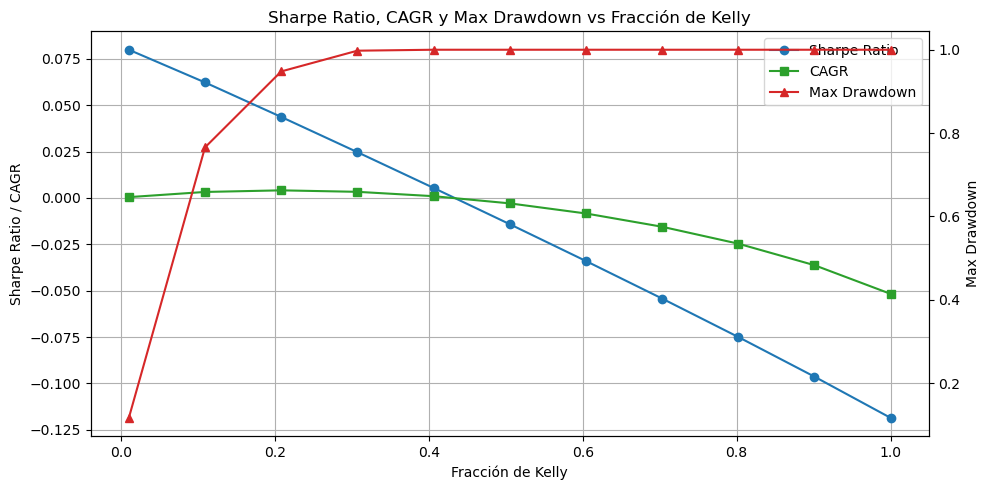

In [285]:
fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.plot(fracs, _sharpe, marker="o", label="Sharpe Ratio", color="tab:blue")
ax1.plot(fracs, _CAGR, marker="s", label="CAGR", color="tab:green")
ax1.set_xlabel("Fracción de Kelly")
ax1.set_ylabel("Sharpe Ratio / CAGR")
ax1.grid(True)

ax2 = ax1.twinx()
ax2.plot(fracs, _max_dd, marker="^", label="Max Drawdown", color="tab:red")
ax2.set_ylabel("Max Drawdown")


lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="best")

plt.title("Sharpe Ratio, CAGR y Max Drawdown vs Fracción de Kelly")
plt.tight_layout()
plt.show()

Podemos observar que apostar la fraccion de Kelly unitaria es demasiado agresivo y lleva a perdidas consistentes de capital. Al utilizar un Kelly fraccional como estrategia mas conservadora se logra una crecimiento positivo del capital con un maximo en aproximadamente ~0.2 de fraccion de Kelly. Al seguir disminuyendo la fraccion de Kelly, el crecimiento del capital se reduce y se entra en un territorio donde hay un tradeoff entre crecimiento y volatilidad.

Enfocandome en el area de mejor performance ~0.2 de fraccion de Kelly.


Estrategia basada en kelly fraccional con fracción 0.05
CAGR: 0.0018
Sharpe Ratio: 0.0729
Max Drawdown: 47.24% 

Estrategia basada en kelly fraccional con fracción 0.08
CAGR: 0.0025
Sharpe Ratio: 0.0680
Max Drawdown: 63.72% 

Estrategia basada en kelly fraccional con fracción 0.11
CAGR: 0.0031
Sharpe Ratio: 0.0629
Max Drawdown: 75.39% 

Estrategia basada en kelly fraccional con fracción 0.13
CAGR: 0.0036
Sharpe Ratio: 0.0577
Max Drawdown: 83.54% 

Estrategia basada en kelly fraccional con fracción 0.16
CAGR: 0.0039
Sharpe Ratio: 0.0525
Max Drawdown: 89.15% 

Estrategia basada en kelly fraccional con fracción 0.19
CAGR: 0.0040
Sharpe Ratio: 0.0473
Max Drawdown: 92.94% 

Estrategia basada en kelly fraccional con fracción 0.22
CAGR: 0.0041
Sharpe Ratio: 0.0420
Max Drawdown: 95.77% 

Estrategia basada en kelly fraccional con fracción 0.24
CAGR: 0.0040
Sharpe Ratio: 0.0367
Max Drawdown: 98.11% 

Estrategia basada en kelly fraccional con fracción 0.27
CAGR: 0.0037
Sharpe Ratio: 0.0314
Max Dr

Text(0.5, 1.0, 'Estrategias de Kelly Fraccional')

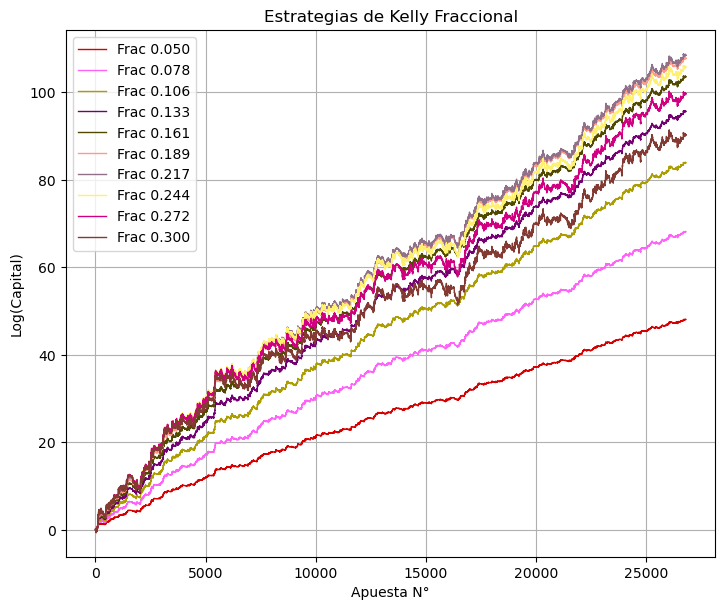

In [286]:
fracs = np.linspace(0.05, 0.3, 10)
n = len(fracs)
_sharpe = []
_max_dd = []
_CAGR = []

for i, frac in enumerate(fracs):
    log_capital, log_returns, cagr, sharpe, max_dd = kelly_fractional(df_bet, frac=frac)
    _sharpe.append(sharpe)
    _CAGR.append(cagr)
    _max_dd.append(max_dd)
    plot_strategy(
        log_capital,
        log_returns,
        cagr,
        sharpe,
        max_dd,
        label=f"Frac {frac:.3f}",
        color=sns.color_palette(cc.glasbey_bw_minc_20_hue_330_100, n_colors=n)[i],
    )

plt.title("Estrategias de Kelly Fraccional")

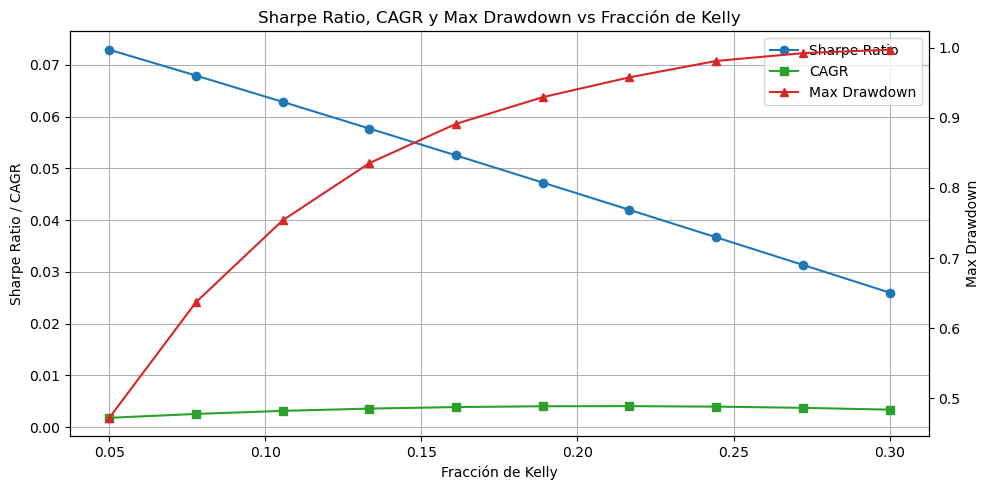

In [287]:
fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.plot(fracs, _sharpe, marker="o", label="Sharpe Ratio", color="tab:blue")
ax1.plot(fracs, _CAGR, marker="s", label="CAGR", color="tab:green")
ax1.set_xlabel("Fracción de Kelly")
ax1.set_ylabel("Sharpe Ratio / CAGR")
ax1.grid(True)

ax2 = ax1.twinx()
ax2.plot(fracs, _max_dd, marker="^", label="Max Drawdown", color="tab:red")
ax2.set_ylabel("Max Drawdown")


lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="best")

plt.title("Sharpe Ratio, CAGR y Max Drawdown vs Fracción de Kelly")
plt.tight_layout()
plt.show()

Estrategia basada en kelly fraccional con fracción 0.10
CAGR: 0.0030
Sharpe Ratio: 0.0639
Max Drawdown: 73.38% 



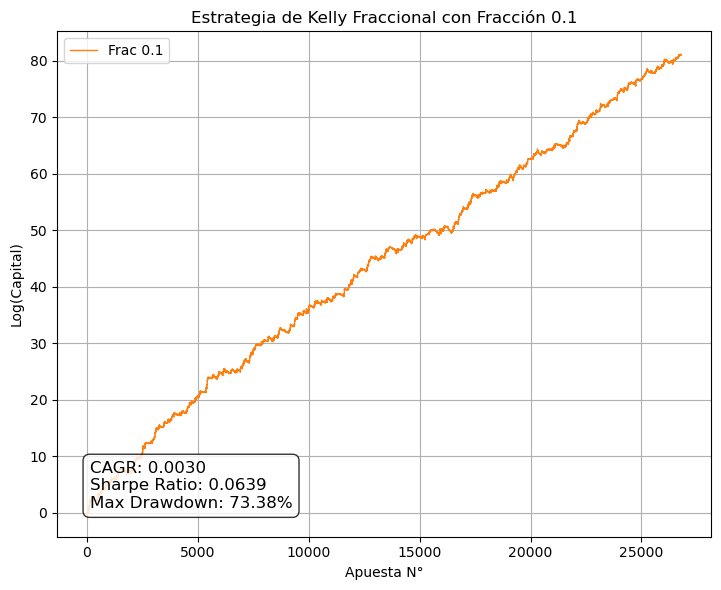

In [288]:
log_capital, log_returns, cagr, sharpe, max_dd = kelly_fractional(df_bet, frac=0.1)
plot_strategy(
    log_capital,
    log_returns,
    cagr,
    sharpe,
    max_dd,
    title="Estrategia de Kelly Fraccional con Fracción 0.1",
    label="Frac 0.1",
    show_metrics=True,
    color="tab:orange",
)

Podemos observar que en esta area los max drawdowns se vuelven tolerables, con crecimiento positivo en todo el rango. De acuerdo con el sharpe ratio, seria posible mejorar la relacion entre la tasa de crecimiento y la volatilidad disminuyendo aun mas la fraccion de Kelly, asumiendo que ambas cosas nos importan en la misma medida.


### Estrategia 2: Fraccion de Kelly con un EV minimo.

- Primero evaluo el EV de apostar por cada jugador, dada la probabilidad de ganar que asigno a cada jugador y los odds.
- Si ambos jugadores tienen EV positivo, apuesto por el jugador con mayor EV. Si ambos tienen EV negativo, no apuesto.
- Solo apuesto si el EV es mayor que un cierto umbral minimo, caso contrario no apuesto.
- Cuando apuesto, apuesto un 10% $f_{kelly}$.

La idea seria estar en una situacion similar a kelly fraccional de 10%, pero evitando apuestas con EV muy bajo. Con esto se pretende controlar la volatilidad potencialmente pagando un costo bajo en el retorno esperado.


In [289]:
def min_ev(df=df_bet, frac=0.1, ev_min=0):
    log_returns = []
    log_capital = [0]  # log(1) = 0

    for i, row in df.iterrows():
        p_win = row["p_model"]
        p_lose = 1 - p_win
        o_win = row["b_winner"]
        o_lose = row["b_loser"]

        # Fracciones de Kelly (f*) para cada jugador
        f_win = (p_win * o_win - 1) / (o_win - 1) if o_win > 1 else 0
        f_lose = (p_lose * o_lose - 1) / (o_lose - 1) if o_lose > 1 else 0

        # EV
        ev_win = p_win * (o_win - 1) - (1 - p_win)
        ev_lose = p_lose * (o_lose - 1) - (1 - p_lose)

        # Ajustar fracciones para kelly fraccional
        f_win = frac * f_win
        f_lose = frac * f_lose

        # Apuesto al maximo EV, ie: fraccion maxima.

        if ev_win > ev_min or ev_lose > ev_min:
            if ev_win >= ev_lose:
                # Apostamos al eventual ganador
                r = np.log(1 + f_win * (o_win - 1))  # ganamos
            else:
                # Apostamos al perdedor
                r = np.log(1 - f_lose)  # perdemos lo apostado

            log_returns.append(r)
            log_capital.append(log_capital[-1] + r)
        else:
            log_returns.append(np.log(1))
            log_capital.append(
                log_capital[-1] + np.log(1)
            )  # no apostamos, capital se mantiene

    # Convertimos a arrays
    log_returns = np.array(log_returns)
    log_capital = np.array(log_capital[1:])  # quitamos capital inicial

    # Métricas
    T = len(log_returns)
    cagr = np.exp((log_capital[-1] - log_capital[0]) / T) - 1 if T > 0 else 0
    sharpe = log_returns.mean() / log_returns.std() if log_returns.std() > 0 else 0
    log_peak = np.maximum.accumulate(log_capital)
    log_drawdown = log_peak - log_capital
    max_dd = 1 - np.exp(-np.max(log_drawdown))

    print(f"Estrategia EV_MIN + Kelly Fraccional 10%,  ev_min: {ev_min:.2f}")
    print(f"CAGR: {cagr:.4f}")
    print(f"Sharpe Ratio: {sharpe:.4f}")
    print(f"Max Drawdown: {max_dd:.2%} \n")
    return log_capital, log_returns, cagr, sharpe, max_dd

Estrategia EV_MIN + Kelly Fraccional 10%,  ev_min: 0.00
CAGR: 0.0030
Sharpe Ratio: 0.0639
Max Drawdown: 73.38% 

Estrategia EV_MIN + Kelly Fraccional 10%,  ev_min: 0.09
CAGR: 0.0031
Sharpe Ratio: 0.0656
Max Drawdown: 72.53% 

Estrategia EV_MIN + Kelly Fraccional 10%,  ev_min: 0.17
CAGR: 0.0031
Sharpe Ratio: 0.0663
Max Drawdown: 69.40% 

Estrategia EV_MIN + Kelly Fraccional 10%,  ev_min: 0.26
CAGR: 0.0031
Sharpe Ratio: 0.0666
Max Drawdown: 66.39% 

Estrategia EV_MIN + Kelly Fraccional 10%,  ev_min: 0.34
CAGR: 0.0031
Sharpe Ratio: 0.0671
Max Drawdown: 62.18% 

Estrategia EV_MIN + Kelly Fraccional 10%,  ev_min: 0.43
CAGR: 0.0030
Sharpe Ratio: 0.0669
Max Drawdown: 62.13% 

Estrategia EV_MIN + Kelly Fraccional 10%,  ev_min: 0.51
CAGR: 0.0029
Sharpe Ratio: 0.0644
Max Drawdown: 62.46% 

Estrategia EV_MIN + Kelly Fraccional 10%,  ev_min: 0.60
CAGR: 0.0027
Sharpe Ratio: 0.0617
Max Drawdown: 61.44% 

Estrategia EV_MIN + Kelly Fraccional 10%,  ev_min: 0.69
CAGR: 0.0026
Sharpe Ratio: 0.0595
Max Dr

Text(0.5, 1.0, 'Estrategia EV_MIN + Kelly Fraccional 10%')

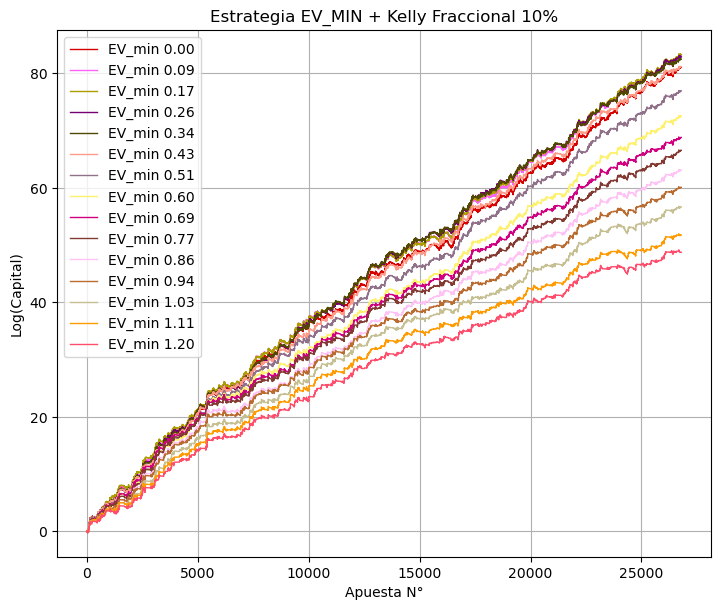

In [290]:
ev_mins = np.linspace(0, 1.2, 15)
n = len(ev_mins)
_sharpe = []
_max_dd = []
_CAGR = []


for i, ev_min in enumerate(ev_mins):
    log_capital, log_returns, cagr, sharpe, max_dd = min_ev(
        df_bet, frac=0.1, ev_min=ev_min
    )
    _sharpe.append(sharpe)
    _CAGR.append(cagr)
    _max_dd.append(max_dd)
    plot_strategy(
        log_capital,
        log_returns,
        cagr,
        sharpe,
        max_dd,
        label=f"EV_min {ev_min:.2f}",
        color=sns.color_palette(cc.glasbey_bw_minc_20_hue_330_100, n_colors=n)[i],
    )

plt.title("Estrategia EV_MIN + Kelly Fraccional 10%")

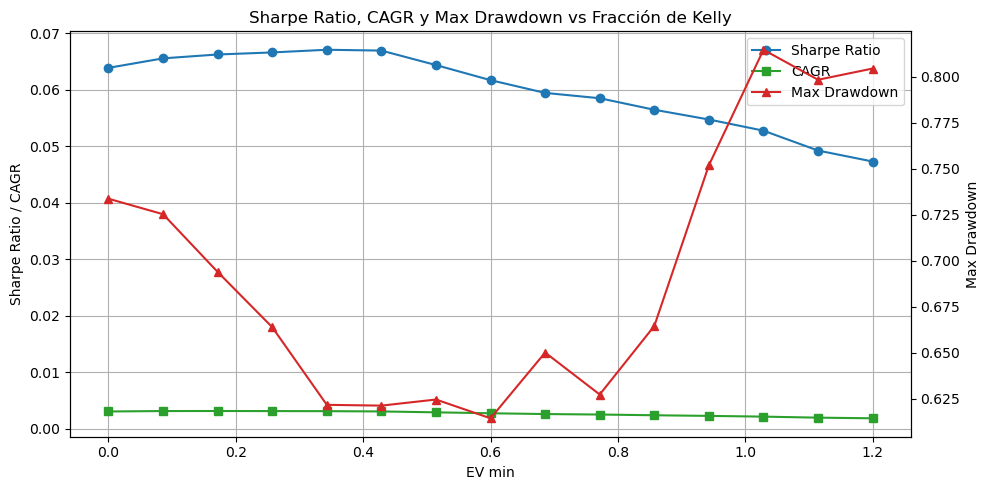

In [291]:
fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.plot(ev_mins, _sharpe, marker="o", label="Sharpe Ratio", color="tab:blue")
ax1.plot(ev_mins, _CAGR, marker="s", label="CAGR", color="tab:green")
ax1.set_xlabel("EV min")
ax1.set_ylabel("Sharpe Ratio / CAGR")
ax1.grid(True)

ax2 = ax1.twinx()
ax2.plot(ev_mins, _max_dd, marker="^", label="Max Drawdown", color="tab:red")
ax2.set_ylabel("Max Drawdown")


lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="best")

plt.title("Sharpe Ratio, CAGR y Max Drawdown vs Fracción de Kelly")
plt.tight_layout()
plt.show()

Al restrigir las apuestas con un minimo de EV se logra reducir la volatilidad y mejorar el Sharpe ratio, pero no de manera muy significativa.


Estrategia EV_MIN + Kelly Fraccional 10%,  ev_min: 0.33
CAGR: 0.0031
Sharpe Ratio: 0.0666
Max Drawdown: 63.31% 



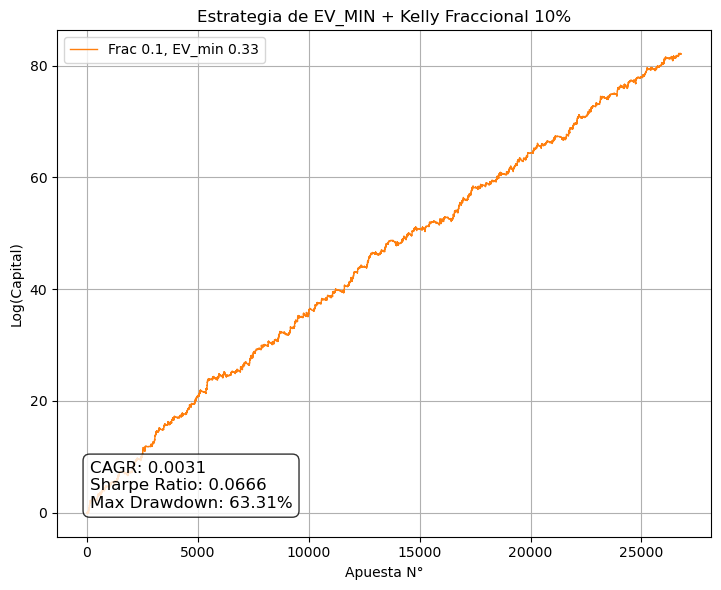

In [292]:
log_capital, log_returns, cagr, sharpe, max_dd = min_ev(df_bet, frac=0.1, ev_min=0.33)
plot_strategy(
    log_capital,
    log_returns,
    cagr,
    sharpe,
    max_dd,
    title="Estrategia de EV_MIN + Kelly Fraccional 10%",
    label="Frac 0.1, EV_min 0.33",
    show_metrics=True,
    color="tab:orange",
)

### Estrategia 3: fraccion de Kelly en funcion de $\sigma_i$


La motivacion seria integrar la informacion de la incertidumbre de las habilidades para la eleccion de la fraccion de Kelly.

Cuando la incertidumbre es mas alta, la fraccion de Kelly es menor y viceversa.

$$f = f_{kelly} \cdot e^{-\lambda (\sigma_w + \sigma_l)}$$


In [344]:
def adaptative_kelly(lam, df=df_bet, ev_min=0):
    log_returns = []
    log_capital = [0]  # log(1) = 0

    for i, row in df.iterrows():
        p_win = row["p_model"]
        p_lose = 1 - p_win
        o_win = row["b_winner"]
        o_lose = row["b_loser"]

        sigma_win = row["s_winner"]
        sigma_lose = row["s_loser"]
        frac = np.exp(-lam * (sigma_win + sigma_lose))

        # Fracciones de Kelly (f*) para cada jugador
        f_win = (p_win * o_win - 1) / (o_win - 1) if o_win > 1 else 0
        f_lose = (p_lose * o_lose - 1) / (o_lose - 1) if o_lose > 1 else 0

        # EV
        ev_win = p_win * (o_win - 1) - (1 - p_win)
        ev_lose = p_lose * (o_lose - 1) - (1 - p_lose)

        # Ajustar fracciones
        f_win = frac * f_win
        f_lose = frac * f_lose

        # Apuesto al maximo EV, ie: fraccion maxima.

        if ev_win > ev_min or ev_lose > ev_min:
            if ev_win >= ev_lose:
                # Apostamos al eventual ganador
                r = np.log(1 + f_win * (o_win - 1))  # ganamos
            else:
                # Apostamos al perdedor
                r = np.log(1 - f_lose)  # perdemos lo apostado

            log_returns.append(r)
            log_capital.append(log_capital[-1] + r)
        else:
            log_returns.append(np.log(1))
            log_capital.append(
                log_capital[-1] + np.log(1)
            )  # no apostamos, capital se mantiene

    # Convertimos a arrays
    log_returns = np.array(log_returns)
    log_capital = np.array(log_capital[1:])  # quitamos capital inicial

    # Métricas
    T = len(log_returns)
    cagr = np.exp((log_capital[-1] - log_capital[0]) / T) - 1 if T > 0 else 0
    sharpe = log_returns.mean() / log_returns.std() if log_returns.std() > 0 else 0
    log_peak = np.maximum.accumulate(log_capital)
    log_drawdown = log_peak - log_capital
    max_dd = 1 - np.exp(-np.max(log_drawdown))

    print(f"Estrategia Kelly adaptativo,  $\lambda$: {lam:.2f}")
    print(f"CAGR: {cagr:.4f}")
    print(f"Sharpe Ratio: {sharpe:.4f}")
    print(f"Max Drawdown: {max_dd:.2%} \n")
    return log_capital, log_returns, cagr, sharpe, max_dd

<>:57: SyntaxWarning: invalid escape sequence '\l'
<>:57: SyntaxWarning: invalid escape sequence '\l'
C:\Users\Damian\AppData\Local\Temp\ipykernel_988\39823694.py:57: SyntaxWarning: invalid escape sequence '\l'
  print(f"Estrategia Kelly adaptativo,  $\lambda$: {lam:.2f}")


<>:19: SyntaxWarning: invalid escape sequence '\l'
<>:19: SyntaxWarning: invalid escape sequence '\l'
C:\Users\Damian\AppData\Local\Temp\ipykernel_988\909046826.py:19: SyntaxWarning: invalid escape sequence '\l'
  label=f"$\lambda :$ {lam:.3f}",


Estrategia Kelly adaptativo,  $\lambda$: 1.00
CAGR: 0.0020
Sharpe Ratio: 0.0131
Max Drawdown: 99.96% 

Estrategia Kelly adaptativo,  $\lambda$: 1.19
CAGR: 0.0030
Sharpe Ratio: 0.0233
Max Drawdown: 99.67% 

Estrategia Kelly adaptativo,  $\lambda$: 1.38
CAGR: 0.0034
Sharpe Ratio: 0.0316
Max Drawdown: 98.73% 

Estrategia Kelly adaptativo,  $\lambda$: 1.56
CAGR: 0.0036
Sharpe Ratio: 0.0383
Max Drawdown: 97.16% 

Estrategia Kelly adaptativo,  $\lambda$: 1.75
CAGR: 0.0035
Sharpe Ratio: 0.0437
Max Drawdown: 94.65% 

Estrategia Kelly adaptativo,  $\lambda$: 1.94
CAGR: 0.0033
Sharpe Ratio: 0.0481
Max Drawdown: 91.18% 

Estrategia Kelly adaptativo,  $\lambda$: 2.12
CAGR: 0.0030
Sharpe Ratio: 0.0516
Max Drawdown: 86.80% 

Estrategia Kelly adaptativo,  $\lambda$: 2.31
CAGR: 0.0027
Sharpe Ratio: 0.0544
Max Drawdown: 81.71% 

Estrategia Kelly adaptativo,  $\lambda$: 2.50
CAGR: 0.0024
Sharpe Ratio: 0.0566
Max Drawdown: 76.10% 



Text(0.5, 1.0, 'Estrategia Kelly Adaptativo')

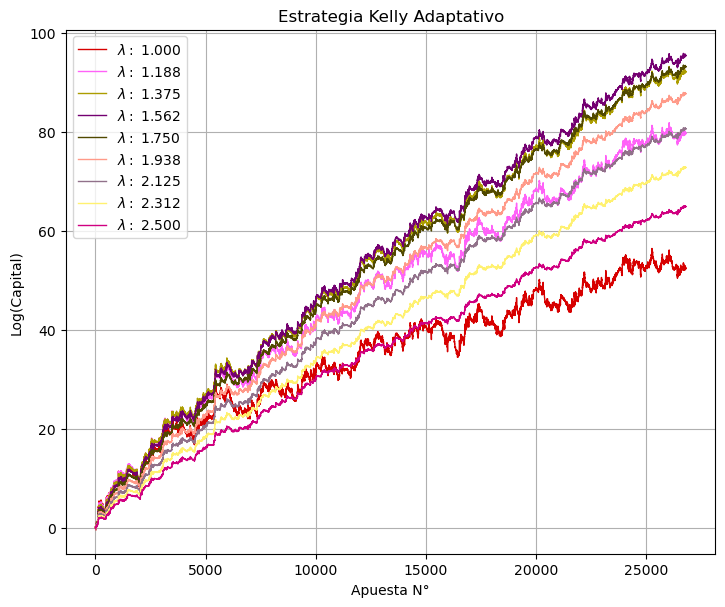

In [350]:
lambdas = np.linspace(1, 2.5, 9)
n = len(lambdas)
_sharpe = []
_max_dd = []
_CAGR = []


for i, lam in enumerate(lambdas):
    log_capital, log_returns, cagr, sharpe, max_dd = adaptative_kelly(lam=lam)
    _sharpe.append(sharpe)
    _CAGR.append(cagr)
    _max_dd.append(max_dd)
    plot_strategy(
        log_capital,
        log_returns,
        cagr,
        sharpe,
        max_dd,
        label=f"$\lambda :$ {lam:.3f}",
        color=sns.color_palette(cc.glasbey_bw_minc_20_hue_330_100, n_colors=n)[i],
    )

plt.title("Estrategia Kelly Adaptativo")

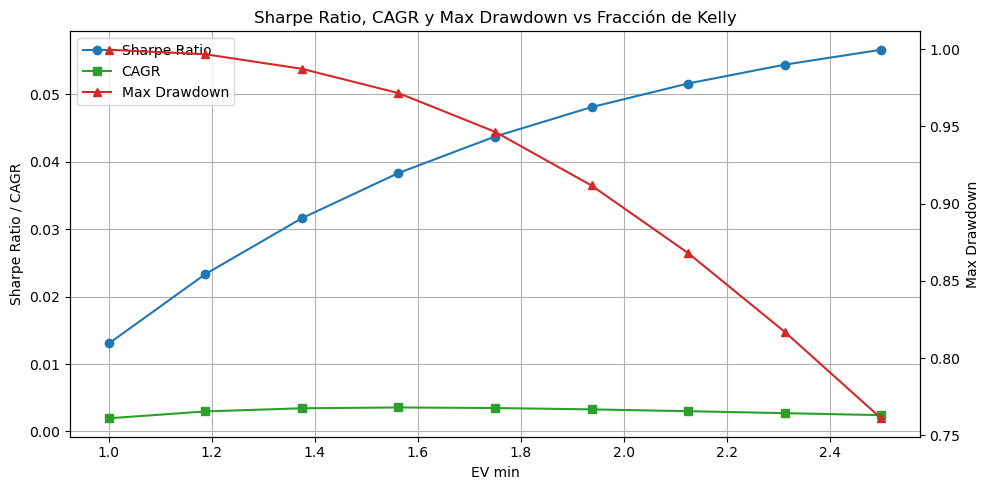

In [352]:
fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.plot(lambdas, _sharpe, marker="o", label="Sharpe Ratio", color="tab:blue")
ax1.plot(lambdas, _CAGR, marker="s", label="CAGR", color="tab:green")
ax1.set_xlabel("EV min")
ax1.set_ylabel("Sharpe Ratio / CAGR")
ax1.grid(True)

ax2 = ax1.twinx()
ax2.plot(lambdas, _max_dd, marker="^", label="Max Drawdown", color="tab:red")
ax2.set_ylabel("Max Drawdown")


lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="best")

plt.title("Sharpe Ratio, CAGR y Max Drawdown vs Fracción de Kelly")
plt.tight_layout()
plt.show()

Estrategia Kelly adaptativo,  $\lambda$: 1.56
CAGR: 0.0039
Sharpe Ratio: 0.0450
Max Drawdown: 96.19% 



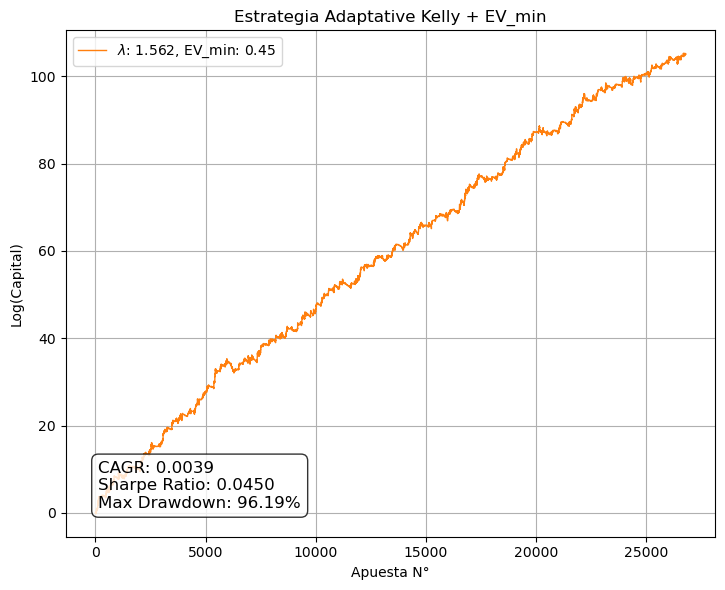

In [ ]:
log_capital, log_returns, cagr, sharpe, max_dd = adaptative_kelly(
    lam=1.562, ev_min=0.45
)
plot_strategy(
    log_capital,
    log_returns,
    cagr,
    sharpe,
    max_dd,
    title="Estrategia Adaptative Kelly + EV_min",
    label=r"$\lambda$: 1.562, EV_min: 0.45",
    show_metrics=True,
    color="tab:orange",
)